In [62]:
MODEL_CHECKPOINT_PATH = '/home/kvu/erc/runs/audio_effnet_b0-2021_03_08-15_00_05/best_metric_F1Weighted.pth'
TEST_DIR = 'data/MELD/raw-audios-wav/test/'
CSV_PATH = 'data/MELD/raw-audios-wav/test.csv'

In [63]:
import sys
sys.path.append('libs')

import csv
import os
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

import pandas
import torch
import yaml
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from PIL import Image
from torchvision import transforms as tvtf
from torch.utils.data import DataLoader
from utils.device import detach, move_to

from utils.getter import get_instance
from datasets import *

import warnings
warnings.filterwarnings("ignore")

## Load weight

In [64]:
config = torch.load(MODEL_CHECKPOINT_PATH)['config']
config

{'id': 'audio_effnet_b0',
 'pretrained': None,
 'model': {'name': 'BaseTimmModel',
  'args': {'name': 'tf_efficientnet_b0_ns',
   'num_classes': 7,
   'freeze_backbone': False,
   'from_pretrained': True}},
 'optimizer': {'name': 'Adam', 'args': {'lr': 1e-05}},
 'loss': {'name': 'FocalLoss', 'args': {}},
 'metric': [{'name': 'F1Weighted', 'args': {}}],
 'scheduler': {'name': 'StepLR',
  'args': {'step_size': 3, 'gamma': 0.2, 'last_epoch': -1}},
 'dataset': {'train': {'name': 'AudioDataset',
   'args': {'data_dir': 'data/MELD/raw-audios-wav/train/',
    'csv_path': 'data/MELD/raw-audios/train.csv',
    'format': '.wav',
    'sr': 22050,
    'duration': 8,
    'n_mels': 128,
    'is_train': True},
   'loader': {'name': 'DataLoader',
    'args': {'batch_size': 4, 'shuffle': True, 'drop_last': True}}},
  'val': {'name': 'AudioDataset',
   'args': {'data_dir': 'data/MELD/raw-audios-wav/val/',
    'csv_path': 'data/MELD/raw-audios/val.csv',
    'format': '.wav',
    'sr': 22050,
    'duratio

In [65]:
dev_id = 'cuda:{}'.format(config['gpus']) \
    if torch.cuda.is_available() and config.get('gpus', None) is not None \
    else 'cpu'

device = torch.device(dev_id)
model = get_instance(config['model']).to(device)
model.load_state_dict(torch.load(MODEL_CHECKPOINT_PATH)['model_state_dict'])

<All keys matched successfully>

## Dataset

In [66]:
test_dataset = AudioDataset(csv_path=CSV_PATH, data_dir=TEST_DIR, format='.wav', is_train=False, sr=22050, duration=8, n_mels=128)
test_dataset_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, pin_memory=False) 

In [67]:
x, y = test_dataset[0]
x.shape

(3, 128, 345)

## Inference

In [68]:
def inference(model, data_loader, device):
    model.eval()
    image_preds_all = []
    ground_truths = []
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs, lbl) in pbar:
        ground_truths.append(lbl)
        imgs = imgs.to(device).float()
        image_preds = model(imgs)
        image_preds_all += [torch.softmax(image_preds, dim=1).detach().cpu().numpy()]
        
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    ground_truths = np.concatenate(ground_truths, axis=0)
    return image_preds_all, ground_truths

In [69]:
test_preds, ground_truths = inference(model, test_dataset_loader, device)

100%|██████████| 653/653 [02:18<00:00,  4.71it/s]


In [70]:
preds = np.argmax(test_preds, axis=1)
print(f1_score(preds, ground_truths, average='weighted'))

0.6186805174580633


In [71]:
del model, config

## Confusion matrix

In [72]:
NUM_CLASSES = 7
classes = ['neutral', 'surprise', 'fear', 'sadness', 'joy', 'disgust', 'anger']

In [73]:
cfm = confusion_matrix(preds, ground_truths, labels=[i for i in range(NUM_CLASSES)])
print(cfm)
cfm = np.around(cfm.astype('float') / cfm.sum(axis=1)[:, np.newaxis], decimals=3)

[[1210  268   47  195  383   66  326]
 [   8    3    0    3    3    1    3]
 [   0    0    0    0    0    0    0]
 [   1    0    0    0    0    0    0]
 [  35   10    3   10   13    1   14]
 [   0    0    0    0    0    0    0]
 [   2    0    0    0    3    0    2]]


In [74]:
cfm_pd = pd.DataFrame(cfm, index=classes, columns=classes)

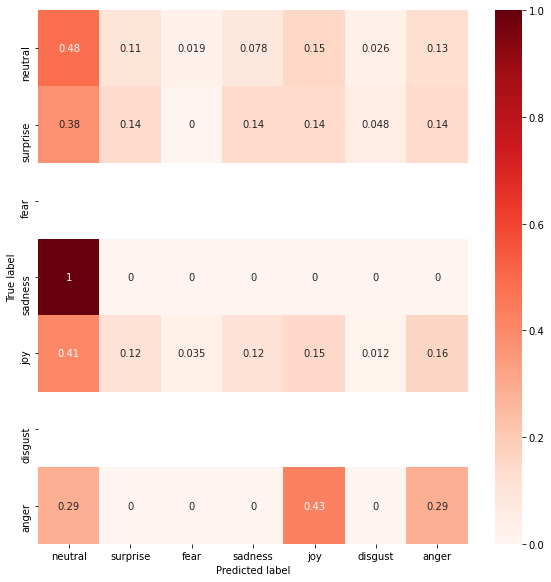

In [75]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(cfm_pd, annot=True, cmap=plt.cm.Reds)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()